# Loan Analysis & Prediction

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


## Exploratory Data Analysis

In [2]:
# file_url = 'https://s3.amazonaws.com/datarobot_public_datasets/DR_Demo_Lending_Club_reduced.csv'
file_path = './input/DR_Demo_Lending_Club_reduced.csv'
df_raw_data = pd.read_csv(file_path)
df_raw_data.head()

,Id,is_bad,emp_length,home_ownership,annual_inc,verification_status,pymnt_plan,purpose_cat,zip_code,addr_state,...,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code
0,1,0,10,MORTGAGE,50000.0,not verified,n,medical,766xx,TX,...,NaN,15.0,0.0,12087,12.1,44.0,f,0.0,1,PC4
1,2,0,1,RENT,39216.0,not verified,n,debt consolidation,660xx,KS,...,NaN,4.0,0.0,10114,64.0,5.0,f,0.0,2,PC1
2,3,0,4,RENT,65000.0,not verified,n,credit card,916xx,CA,...,NaN,4.0,0.0,81,0.6,8.0,f,0.0,3,PC4
3,4,0,10,MORTGAGE,57500.0,not verified,n,debt consolidation,124xx,NY,...,NaN,6.0,0.0,10030,37.1,23.0,f,0.0,2,PC2
4,5,0,10,MORTGAGE,50004.0,VERIFIED - income,n,debt consolidation,439xx,OH,...,NaN,8.0,0.0,10740,40.4,21.0,f,0.0,3,PC3


Data Describe

                Id        is_bad     annual_inc  debt_to_income  delinq_2yrs  \
count  10000.00000  10000.000000    9999.000000    10000.000000  9995.000000   
mean    5000.50000      0.129500   68203.011539       13.338704     0.148174   
std     2886.89568      0.335769   48590.252757        6.754212     0.506270   
min        1.00000      0.000000    2000.000000        0.000000     0.000000   
25%     2500.75000      0.000000   40000.000000        8.160000     0.000000   
50%     5000.50000      0.000000   58000.000000       13.410000     0.000000   
75%     7500.25000      0.000000   82000.000000       18.692500     0.000000   
max    10000.00000      1.000000  900000.000000       29.990000    11.000000   

       inq_last_6mths  mths_since_last_delinq  mths_since_last_record  \
count     9995.000000             3684.000000              840.000000   
mean         1.066933               35.890337               61.652381   
std          1.476052               22.361443

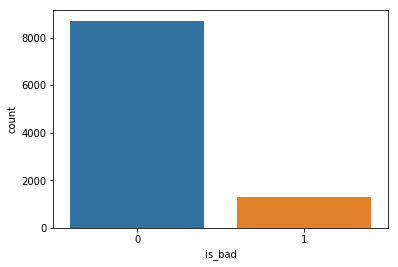

In [3]:
print('Data Describe\n')
print(df_raw_data.describe())
sns.countplot(x='is_bad', data=df_raw_data)

In [4]:
print('Data Describe - Annual Income and Number of times the loan applicant has missed a loan repayment during the past 2 years\n')
print(df_raw_data[['annual_inc','delinq_2yrs']].describe())



Data Describe - Annual Income and Number of times the loan applicant has missed a loan repayment during the past 2 years

          annual_inc  delinq_2yrs
count    9999.000000  9995.000000
mean    68203.011539     0.148174
std     48590.252757     0.506270
min      2000.000000     0.000000
25%     40000.000000     0.000000
50%     58000.000000     0.000000
75%     82000.000000     0.000000
max    900000.000000    11.000000


In [5]:
print('Data Corr\n')
print(df_raw_data.corr())

Data Corr

                                   Id    is_bad  annual_inc  debt_to_income  \
Id                           1.000000  0.010883    0.002736        0.014795   
is_bad                       0.010883  1.000000   -0.050975        0.029873   
annual_inc                   0.002736 -0.050975    1.000000       -0.130184   
debt_to_income               0.014795  0.029873   -0.130184        1.000000   
delinq_2yrs                 -0.000116  0.021842    0.038670       -0.034393   
inq_last_6mths               0.015789 -0.001146    0.056718        0.012819   
mths_since_last_delinq       0.010847  0.001358   -0.024578        0.057264   
mths_since_last_record      -0.001643  0.135735    0.006997        0.135642   
open_acc                     0.016304 -0.020356    0.233821        0.301003   
pub_rec                     -0.002248  0.032174   -0.010398       -0.005351   
revol_bal                    0.007223 -0.016202    0.359817        0.163794   
revol_util                   0.014310  0.

## Data Preprocessing

In [6]:
from preprocessing import preprocess, check_input_validation

# ordinal_categorical_fields_mapping = {
#     "pymnt_plan": {"n": 0, "y": 1},
#     "initial_list_status": {"f": 0, "m": 1},
#     "home_ownership": {"NONE": 1, "OTHER": 2, "MORTGAGE": 3, "RENT": 4, "OWN":  5},
#     "policy_code": {"PC1": 1, "PC2": 2, "PC3": 3, "PC4": 4, "PC5":  5},
#     "verification_status": {"not verified": 0, "VERIFIED - income": 1, "VERIFIED - income source": 1},
# }
ordinal_categorical_fields_mapping = {}
nominal_categorical_fields = [
    "pymnt_plan",
    "initial_list_status",
    "home_ownership",
    "policy_code",
    "verification_status",
    "purpose_cat",
    "addr_state",
    "zip_code",
]

drop_fields = [
    "Id", 
#     "mths_since_last_delinq",
#     "mths_since_last_record",
#     "addr_state",
#     "zip_code", 
]

df_data = preprocess(data=df_raw_data, 
                     ordinal_categorical_fields_mapping=ordinal_categorical_fields_mapping, 
                     nominal_categorical_fields=nominal_categorical_fields,
                     drop_fields=drop_fields
                    )




Missing values:
------------------------------------
Id                                0
is_bad                            0
emp_length                        0
home_ownership                    0
annual_inc                        1
verification_status               0
pymnt_plan                        0
purpose_cat                       0
zip_code                          0
addr_state                        0
debt_to_income                    0
delinq_2yrs                       5
inq_last_6mths                    5
mths_since_last_delinq         6316
mths_since_last_record         9160
open_acc                          5
pub_rec                           5
revol_bal                         0
revol_util                       26
total_acc                         5
initial_list_status               0
collections_12_mths_ex_med       32
mths_since_last_major_derog       0
policy_code                       0
dtype: int64


10000

Categorical values:
------------------------------------

py

In [7]:
# Check input data validation.
check_input_validation(df_data)


Checking the input data validation.............................


True

## Partitioning a dataset in training and test sets

In [8]:
from sklearn.model_selection import train_test_split

X = df_data.drop('is_bad', axis=1)
y = df_data['is_bad'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

## Training a logistic regression model

In [24]:
from prediction_model import PredictionModel

# solver: {‘newton-cg’, ‘lbfgs’, ‘liblinear’, ‘sag’, ‘saga’}
model = PredictionModel(solver='liblinear', 
                        penalty='l1', 
                        max_iter=1000, 
                        C=1000, 
                        debug=True)

In [25]:
model.fit(X_train, y_train)

LogisticRegression(C=1000, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='warn', n_jobs=None, penalty='l1',
                   random_state=0, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [26]:
# Training accuracy
eval_train = model.evaluate(X_train, y_train)
print('Training evaluation:', eval_train)

[[6045   35]
 [ 714  206]]
Training evaluation: {'f1_score': 0.35486649440137813, 'log_loss': 3.695653072242595}


## Evaluate model

In [27]:
# Test accuracy
eval_test = model.evaluate(X_test, y_test)
print('Test evaluation:', eval_test)



[[2586   39]
 [ 317   58]]
Test evaluation: {'f1_score': 0.24576271186440682, 'log_loss': 4.098611860295994}


## Predict

In [28]:
model.predict(X_test[0:50])

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0])

In [29]:
model.predict_proba(X_test[0:50])

array([[8.48106196e-01, 1.51893804e-01],
       [7.76229846e-01, 2.23770154e-01],
       [8.86087264e-01, 1.13912736e-01],
       [6.67304973e-01, 3.32695027e-01],
       [6.59211046e-01, 3.40788954e-01],
       [9.64537882e-01, 3.54621177e-02],
       [9.98007759e-01, 1.99224066e-03],
       [7.06086825e-01, 2.93913175e-01],
       [9.99968532e-01, 3.14677145e-05],
       [9.23154781e-01, 7.68452193e-02],
       [6.85916512e-01, 3.14083488e-01],
       [9.84033620e-01, 1.59663803e-02],
       [9.39475081e-01, 6.05249192e-02],
       [9.99791808e-01, 2.08192269e-04],
       [9.03518861e-01, 9.64811395e-02],
       [9.99960495e-01, 3.95046076e-05],
       [9.70315654e-01, 2.96843464e-02],
       [6.83481642e-01, 3.16518358e-01],
       [7.86328650e-01, 2.13671350e-01],
       [9.99646785e-01, 3.53214559e-04],
       [8.99906436e-01, 1.00093564e-01],
       [8.01899862e-01, 1.98100138e-01],
       [8.73353778e-01, 1.26646222e-01],
       [8.83155045e-01, 1.16844955e-01],
       [9.999874

## Tune hyperparameters

In [31]:
# The evaluation of all possible parameter combinations is computationally very expensive.
# Therefore, used the only 200 training data set here.
# best_params = model.tune_parameters(X_train, y_train)
best_params = model.tune_parameters(X_train[:200], y_train[:200])
print(best_params)


Tuning hyperparameters: It will take time.............
best score = 0.89
best params = {'C': 1, 'fit_intercept': True, 'solver': 'liblinear', 'tol': 0.001}
{'C': 1, 'fit_intercept': True, 'solver': 'liblinear', 'tol': 0.001}


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
